Digging into timeseries forecasting as part of the WiDS 2023 Challenge

In [1]:
# Base libraries
import numpy as np
import pandas as pd
import itertools

In [18]:
# Stats and ML libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from prophet import Prophet

In [3]:
# Plotting libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(rc={"figure.figsize":(8, 4), "figure.dpi":300}) # width=8, height=4

In [4]:
# Read in the datasets
df = pd.read_csv("train_data.csv")
df = df.set_index('index') # Set column 'index' as the index of rows

test_df = pd.read_csv("test_data.csv")
test_df = test_df.set_index('index')

In [5]:
def process_date(df):
    # Convert datetime into pandas parsable format
    df["startdate"] = pd.to_datetime(df["startdate"])

    # Extract day, month and year from startdate column
    df['day'] = df['startdate'].dt.day
    df['month'] = df['startdate'].dt.month
    df['year'] = df['startdate'].dt.year
    # df = df.drop(columns=['startdate'])
    
    return df

In [6]:
df = process_date(df)
test_df = process_date(test_df)

In [7]:
def add_season(dataframe):
    month_to_season = {12: 0, 1: 0, 2: 0,
                       3: 1, 4: 1, 5: 1,
                       6: 2, 7: 2, 8: 2,
                       9: 3, 10: 3, 11: 3}
    dataframe['season'] = dataframe['month'].apply(lambda x: month_to_season[x])
    return dataframe

In [8]:
df = add_season(df)
test_df = add_season(test_df)

Visualize data to start

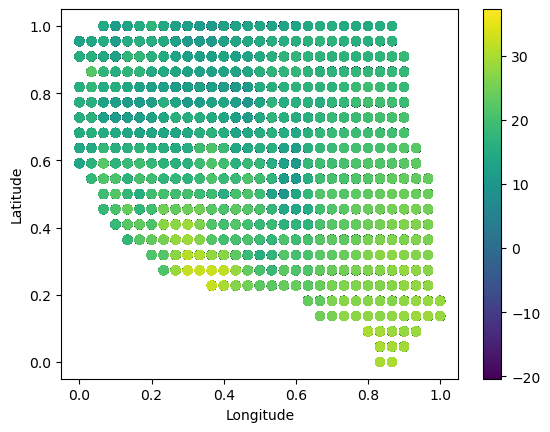

In [10]:
#  Scatter plot of latitude and longitude, with temperature indicated by color. 
fig = plt.scatter(x=df['lon'], y=df['lat'], c=df['contest-tmp2m-14d__tmp2m'])  # can also shade as climatic regions
plt.colorbar(fig)
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()

C:\tools\Anaconda3\envs\cdemand_env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='contest-tmp2m-14d__tmp2m', ylabel='Density'>

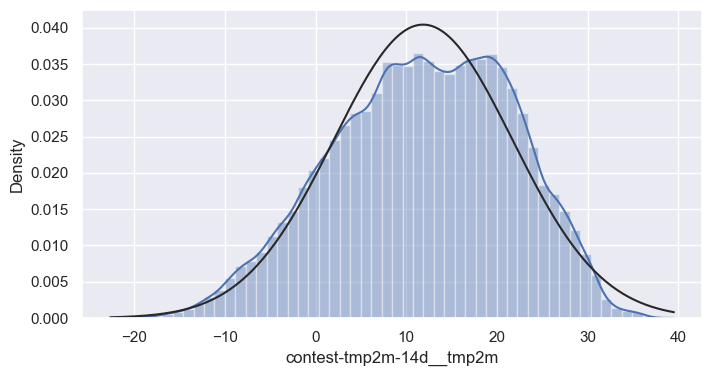

In [19]:
# Analysis of the target variable 'contest-tmp2m-14d__tmp2m'
# Distribution plot along with the standard gaussian curve for target varible
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)
sns.distplot(df['contest-tmp2m-14d__tmp2m'], fit=norm)

'\nObservation: The time series dataset is highly seasonal and no up/down trend\n'

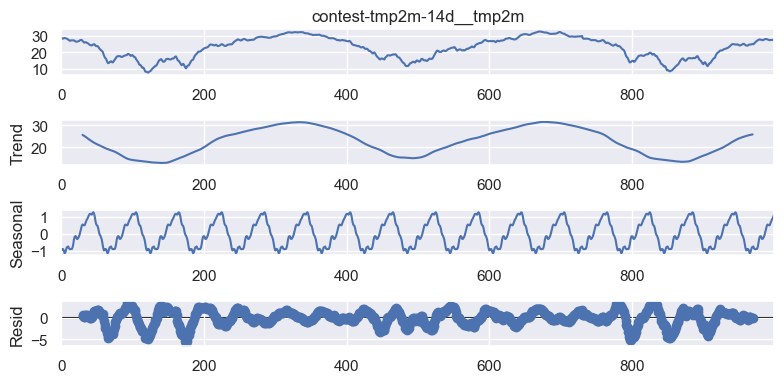

In [20]:
# Time series decomposition of 'contest-tmp2m-14d__tmp2m' target variable
def decomposition(input_df: pd.DataFrame,
                  decomposition_type: str = 'multiplicative',
                  period: int = 60):
    """
    Given a pandas DataFrame, this function performs a time series decomposition and plots the results.
    
    Parameters:
    input_df (pandas.DataFrame): A pandas DataFrame with a time series to be decomposed.
    decomposition_type (str, optional): The type of decomposition to be performed. The default is 'multiplicative'.
    period (int, optional): The number of observations per cycle. The default is 60.
    
    Returns:
    None
    
    Note:
    This function requires the statsmodels library.
    """
    decomposed = seasonal_decompose(input_df, model=decomposition_type, period=period)
    decomposed.plot()
    return

# Plot the time series decomposition of the training dataset
# We use only first 10,000 samples for better visualization
decomposition(df['contest-tmp2m-14d__tmp2m'][:1000], decomposition_type = 'additive')

'''
Observation: The time series dataset is highly seasonal and no up/down trend
'''

Examine correlations

Feature engineering

In [9]:
# Adding cyclical feature engineering
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclical(dataframe):
    # Encode the day with a period of 365
    dataframe['day_of_year_sin'] = sin_transformer(365).fit_transform(dataframe['day'])
    dataframe['day_of_year_cos'] = cos_transformer(365).fit_transform(dataframe['day'])

    # Encode the month with a period of 12
    dataframe['month_sin'] = sin_transformer(12).fit_transform(dataframe['month'])
    dataframe['month_cos'] = cos_transformer(12).fit_transform(dataframe['month'])

    # Encode the season with a period of 4
    dataframe['season_sin'] = sin_transformer(4).fit_transform(dataframe['season'])
    dataframe['season_cos'] = cos_transformer(4).fit_transform(dataframe['season'])
    return dataframe

In [10]:
# Did work in other notebook to determine these predictors
predictors = ['contest-prwtr-eatm-14d__prwtr', 'contest-rhum-sig995-14d__rhum', 'contest-slp-14d__slp', 'contest-pevpr-sfc-gauss-14d__pevpr']

X = df[predictors]
y = df['contest-tmp2m-14d__tmp2m']

# print(X.head())

In [11]:
# Scale Values
# Step 1: define a MinMax scalar that will transform the data values into values in (0, 1)
scalar = MinMaxScaler()

# Step 2: fit the MinMaxScaler using our data
values = X.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).values
test_values = test_df[predictors].select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).values

# Fit only on the train dataset
scalar.fit(values)

# Step 3: Scale the values in our dataset
values_scaled = scalar.transform(values)
test_values_scaled = scalar.transform(test_values)

In [12]:
# Create dataframe on scaled values
X = pd.DataFrame(values_scaled, columns=X.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns, index=df.index)
test_X = pd.DataFrame(test_values_scaled, columns=test_df[predictors].select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns, index=test_df[predictors].index)

Consider location of temperature data points, specifically:
- Which lat/long pairings (referred to here forward as locations) are in which climate region?
- Is the temperature data (and other data) for each location aligned in time?

In [13]:
# Find number of unique lat/longs and lat/long pairings
print("unique lats:", len(df['lat'].unique()))
print("unique longs:", len(df['lon'].unique()))

df['lat_lon'] = df['lat'].astype(str) + '_' + df['lon'].astype(str)
test_df['lat_lon'] = test_df['lat'].astype(str) + '_' + test_df['lon'].astype(str)
print("unique lat/long combos (locations):", len(df['lat_lon'].unique()))

unique lats: 23
unique longs: 31
unique lat/long combos (locations): 514


In [14]:
dict_regions = {}

def climate_regions(dataframe):
    for region in dataframe['climateregions__climateregion'].unique():
        df_cr = dataframe[dataframe['climateregions__climateregion'] == region]
        dict_regions[region] = [len(df_cr['lat_lon'].unique()), df_cr['startdate'].min()]
        
    return dict_regions

In [15]:
dict_cr = climate_regions(df)
print("climate region: # of locs within region, data start date")
dict_cr

climate region: # of locs within region, data start date


{'BSh': [7, Timestamp('2014-09-01 00:00:00')],
 'Cfa': [71, Timestamp('2014-09-01 00:00:00')],
 'BSk': [191, Timestamp('2014-09-01 00:00:00')],
 'BWk': [19, Timestamp('2014-09-01 00:00:00')],
 'BWh': [13, Timestamp('2014-09-01 00:00:00')],
 'Csa': [13, Timestamp('2014-09-01 00:00:00')],
 'Csb': [56, Timestamp('2014-09-01 00:00:00')],
 'Cfb': [6, Timestamp('2014-09-01 00:00:00')],
 'Dfb': [72, Timestamp('2014-09-01 00:00:00')],
 'Dsc': [4, Timestamp('2014-09-01 00:00:00')],
 'Dfc': [17, Timestamp('2014-09-01 00:00:00')],
 'Dfa': [31, Timestamp('2014-09-01 00:00:00')],
 'Dsb': [11, Timestamp('2014-09-01 00:00:00')],
 'Dwa': [2, Timestamp('2014-09-01 00:00:00')],
 'Dwb': [1, Timestamp('2014-09-01 00:00:00')]}


Let's look at temperature timeseries for locations in four of the climate regions:

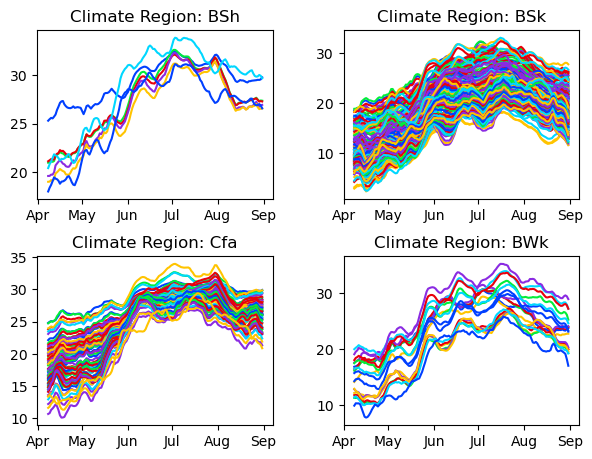

In [39]:
fig, axs = plt.subplots(2,2)
fig.tight_layout(pad=2)
plt.style.use('seaborn-v0_8-bright')
clear_labels = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
nrow = [0, 1, 0, 1]
ncol = [0, 0, 1, 1]
counter = 0

for region in df['climateregions__climateregion'].unique()[0:4]:
    
    # Get climate region
    df_cr = df[df['climateregions__climateregion'] == region]
    for ll_combo in df_cr['lat_lon'].unique():
        
        # Extract just one location
        df_ll = df_cr[df_cr['lat_lon'] == ll_combo]

        # Need the scaled dataset X for that location
        X_ll = X.loc[df_ll.index]
        y_ll = y.loc[df_ll.index]
        date_ll = df.loc[df_ll.index, ['startdate', 'month']]

        # Create train & test dataset for that location
        four_fifths = round(len(X_ll) * 0.8)
        
        X_ll_train = X_ll[0:four_fifths]
        y_ll_train = y_ll[0:four_fifths]
        
        X_ll_test = X_ll[four_fifths:]
        y_ll_test = y_ll[four_fifths:]
        
        axs[nrow[counter], ncol[counter]].plot(date_ll[four_fifths:]['startdate'], y_ll_test)
        ticks = axs[nrow[counter], ncol[counter]].get_xticks()
        axs[nrow[counter], ncol[counter]].set_xticks(ticks=ticks, labels=clear_labels)
        axs[nrow[counter], ncol[counter]].set_title("Climate Region: " + region)

    counter += 1

Model fitting
- Start by working with 1 location in 1 climate region - the last location in the BWh region

In [40]:
df_prophet_train = pd.concat([date_ll[0:four_fifths], y_ll_train, X_ll_train], axis=1)
df_prophet_train = df_prophet_train.rename(columns={'startdate': 'ds', 'contest-tmp2m-14d__tmp2m': 'y'})
df_prophet_test = pd.concat([date_ll[four_fifths:], y_ll_test, X_ll_test], axis=1)
df_prophet_test = df_prophet_test.rename(columns={'startdate': 'ds', 'contest-tmp2m-14d__tmp2m': 'y'})

In [20]:
# run algorithm
m = Prophet(growth='linear', daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
for col in df_prophet_train.columns[2:]:
    m.add_regressor(col)
m.fit(df_prophet_train)
results = m.predict(df_prophet_test)

13:46:33 - cmdstanpy - INFO - Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing


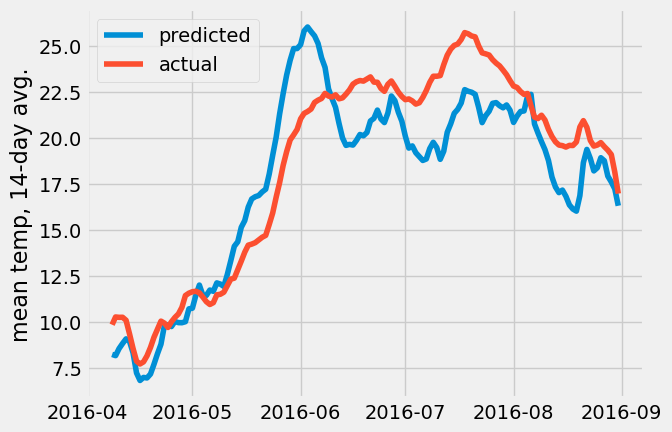

In [21]:
plt.style.use('fivethirtyeight')
plt.plot(results['ds'], results['yhat'], label='predicted')
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label='actual')
plt.ylabel('mean temp, 14-day avg.', fontsize=16)
plt.legend()
plt.show()

How to best make use of many datasets in the same region that contain less than a year of daily temperature measurements?